In [10]:
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../../RKLM_Python/')
# Path to output files
sys.path.append('../')

import numpy as np
import utils
import plotting_tools as pt

from importlib import reload
import utils
utils = reload(utils)
pt = reload(pt)

from scipy import signal
import pickle

# Initial blending plotter
For the Euler and shallow water vortices

In [5]:
# Do we plot SWE or Euler vortex?
swe = False

## Comparison with imbalanced initial conditions

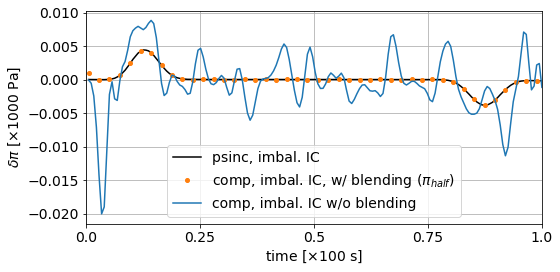

In [6]:
attributes = ['rho','rhou','rhov','rhoY','p2_nodes']
attributes = ['p2_nodes']

et = 1.0

if swe:
    base_fn = "output_swe_vortex"
    directory = "output_swe_vortex"
    # path to output directory
    py_directory = "../../%s/" %directory
    
    Nx, Ny, Nz = 64, 1, 64
    tc = utils.test_case(base_fn,py_directory,Nx,Ny,et,Nz=Nz)
    p_ref = 10.0
else:
    base_fn = "output_travelling_vortex"
    directory = "output_travelling_vortex"
    # path to output directory
    py_directory = "../../%s/" %directory
    
    Nx, Ny = 64, 64
    tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
    p_ref = 10.0
    
times = np.arange(0,176)
t_axs = np.linspace(0.0,1.0,5)
t_pos = np.linspace(0,175,5)
probe_loc = [32,32]
l_typ = 'WINDOW_STEP'

attr_labels = pt.labels_increment()

def get_ens(sfx , diff, attribute):
    ens = tc.get_ensemble(times, 1, attribute, sfx, label_type=l_typ, avg=True, diff=diff)
    if swe: ens = ens[:,:,0,:] # project 3D to 2D
    probe = ens[:,probe_loc[0],probe_loc[1]] * p_ref
    probe = probe[1:] # remove first time-step

    label = sfx + '_' + attribute
    return probe

pls = []

for i,attribute in enumerate(attributes):
    diff = True if attribute == 'p2_nodes' else False

    sfx1 = 'psinc_noib'
    sfx2a = 'comp_imbal_noib'
    sfx2b = 'comp_imbal_full_ib-16'
    sfx2c = 'comp_imbal_half_ib-0'
    sfx3 = 'comp_imbal_noib'

    p1 = get_ens(sfx1, diff, attribute)
    p2b = get_ens(sfx2b, diff, attribute)
    p2c = get_ens(sfx2c, diff, attribute)
    p3 = get_ens(sfx3, diff, attribute)

    fs = (8,4) # fs used in draft
    pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=1,nrows=1)
    ax = pl.get_ax(i)

    if diff == True: times = times[1:]
    
    ref = 'lake' if swe else 'psinc'
    full = 'SWE' if swe else 'comp'
    ic = 'imbal.' if 'imbal' in sfx3 else 'bal.'
    l1 = '%s, imbal. IC' %(ref)
    l2c = r'%s, imbal. IC, w/ blending ($\pi_{half}$)' %full
    l2b = r'%s, imbal. IC, w/ blending ($\pi_{full}$)' %full
    l3 = '%s, %s IC w/o blending' %(full, ic)
    ic = ic[:-1]

    ax.plot(times, p1, 'k', label=l1)
#     ax.plot(times, p2b, 'C0o', ms=4, markevery=4, label=l2b)
    ax.plot(times, p2c, 'C1o', ms=4, markevery=4, label=l2c)
    ax.plot(times, p3, 'C0', label=l3)

    ax.set_xlim([times[0],times[-1]])
    if swe:
        ax.set_xlabel(r'time [$\times 100$ s]')
        ax.set_ylabel(r'$\delta h$ [m]')
    else:
        ax.set_xlabel(r'time [$\times 100$ s]')
        ax.set_ylabel(r'$\delta \pi$ [$\times 1000$ Pa]')
        
    ax.set_xticks(t_pos)
    ax.set_xticklabels(t_axs)
    ax.grid()
    ax.legend()
    pl.img.tight_layout()
    
    fn = 'swe' if swe else 'euler'
    pl.save_fig('./output/%s_w_%s' %(fn, ic))

## Comparison with balanced initial conditions

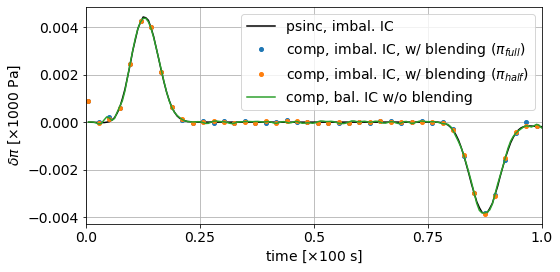

In [7]:
attributes = ['rho','rhou','rhov','rhoY','p2_nodes']
attributes = ['p2_nodes']

et = 1.0

if swe:
    base_fn = "output_swe_vortex"
    directory = "output_swe_vortex"
    # path to output directory
    py_directory = "../../%s/" %directory
    
    Nx, Ny, Nz = 64, 1, 64
    tc = utils.test_case(base_fn,py_directory,Nx,Ny,et,Nz=Nz)
    p_ref = 10.0
else:
    base_fn = "output_travelling_vortex"
    directory = "output_travelling_vortex"
    # path to output directory
    py_directory = "../../%s/" %directory
    
    Nx, Ny = 64, 64
    tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
    p_ref = 10.0
    
times = np.arange(0,176)
t_axs = np.linspace(0.0,1.0,5)
t_pos = np.linspace(0,175,5)
probe_loc = [32,32]
l_typ = 'WINDOW_STEP'

attr_labels = pt.labels_increment()

def get_ens(sfx , diff, attribute):
    ens = tc.get_ensemble(times, 1, attribute, sfx, label_type=l_typ, avg=True, diff=diff)
    if swe: ens = ens[:,:,0,:] # project 3D to 2D
    probe = ens[:,probe_loc[0],probe_loc[1]] * p_ref
    probe = probe[1:] # remove first time-step

    label = sfx + '_' + attribute
    return probe

pls = []

for i,attribute in enumerate(attributes):
    diff = True if attribute == 'p2_nodes' else False

    sfx1 = 'psinc_noib'
    sfx2a = 'comp_imbal_noib'
    sfx2b = 'comp_imbal_full_ib-16'
    sfx2c = 'comp_imbal_half_ib-0'
    sfx3 = 'comp_bal_noib'

    p1 = get_ens(sfx1, diff, attribute)
    p2b = get_ens(sfx2b, diff, attribute)
    p2c = get_ens(sfx2c, diff, attribute)
    p3 = get_ens(sfx3, diff, attribute)

    fs = (8,4) # fs used in draft
    pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=1,nrows=1)
    ax = pl.get_ax(i)

    if diff == True: times = times[1:]
    
    ref = 'lake' if swe else 'psinc'
    full = 'SWE' if swe else 'comp'
    ic = 'imbal.' if 'imbal' in sfx3 else 'bal.'
    l1 = '%s, imbal. IC' %(ref)
    l2c = r'%s, imbal. IC, w/ blending ($\pi_{half}$)' %full
    l2b = r'%s, imbal. IC, w/ blending ($\pi_{full}$)' %full
    l3 = '%s, %s IC w/o blending' %(full, ic)
    ic = ic[:-1]

    ax.plot(times, p1, 'k', label=l1)
    ax.plot(times, p2b, 'C0o', ms=4, markevery=4, label=l2b)
    ax.plot(times, p2c, 'C1o', ms=4, markevery=4, label=l2c)
    ax.plot(times, p3, 'C2', label=l3)

    ax.set_xlim([times[0],times[-1]])
    if swe:
        ax.set_xlabel(r'time [$\times 100$ s]')
        ax.set_ylabel(r'$\delta h$ [m]')
    else:
        ax.set_xlabel(r'time [$\times 100$ s]')
        ax.set_ylabel(r'$\delta \pi$ [$\times 1000$ Pa]')
        
    ax.set_xticks(t_pos)
    ax.set_xticklabels(t_axs)
    ax.grid()
    ax.legend()
    pl.img.tight_layout()
    
    fn = 'swe' if swe else 'euler'
    pl.save_fig('./output/%s_w_%s' %(fn, ic))